# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

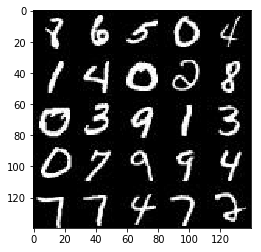

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

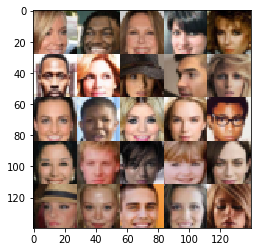

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/daisor/Dev/Env/p36tf1.1/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    imgs = tf.placeholder(
        dtype=tf.float32, 
        shape=(None, image_width, image_height, image_channels), 
        name='images' 
    )
    noises = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='noise')
    
    lr = tf.placeholder(dtype=tf.float32, shape=None, name='lr')
    
    return imgs, noises, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [92]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

conv_last_height = None
conv_last_width = None
conv_last_channel = None

hp_smooth_alpha = .9
hp_dropout = .25
hp_leaky_relu_alhpa = .2

In [94]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(
            inputs=inputs, filters=filters, kernel_size=5, strides=2, padding='same',
            kernel_initializer = tf.contrib.layers.xavier_initializer()
        )
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
            
        outputs = leaky_relu(x=outputs, alpha=hp_leaky_relu_alhpa)
        outputs = tf.layers.dropout(inputs=outputs, rate=hp_dropout)
        return outputs

    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(inputs=images, filters=64, batch_norm=False)  # 14*14*64

        x2 = conv(inputs=x1, filters=128)  # 7*7*128

#         x3 = conv(inputs=x2, filters=256)  # 4*4*256
        
        # 鉴别器最后的卷积输出shape，作为生成器反卷积的输入shape。
        last_conv = x2
        global conv_last_height, conv_last_width, conv_last_channel
        conv_last_height = last_conv.shape[1].value
        conv_last_width = last_conv.shape[2].value
        conv_last_channel = last_conv.shape[3].value
        
        flat = tf.reshape(
            tensor=last_conv, shape=(-1, conv_last_height * conv_last_width * conv_last_channel)
        )
        # flat = tf.reshape(tensor=x3, shape=(-1, 4, 4, 256))

        logits = tf.layers.dense(inputs=flat, units=1)
        out = tf.sigmoid(x=logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [95]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    global conv_last_height, conv_last_width, conv_last_channel
    
    with tf.variable_scope("generator", reuse=not is_train):

        x1 = tf.layers.dense(inputs=z, units=conv_last_height * conv_last_width * conv_last_channel)
        x1 = tf.reshape(x1, (-1, conv_last_height, conv_last_width, conv_last_channel))
        
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x=x1)
        x1 = tf.layers.dropout(inputs=x1, rate=hp_dropout)

        x2 = tf.layers.conv2d_transpose(
            inputs=x1, filters=256, kernel_size=5, strides=1, padding='SAME',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x=x2)
        x2 = tf.layers.dropout(inputs=x2, rate=hp_dropout)

        x3 = tf.layers.conv2d_transpose(
            inputs=x2, filters=128, kernel_size=5, strides=2, padding='SAME',
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x=x3)
        x3 = tf.layers.dropout(inputs=x3, rate=hp_dropout)


#         x4 = tf.layers.conv2d_transpose(x3, 64, 5, 2, 'SAME')
#         x4 = tf.layers.batch_normalization(x4, training=is_train)
#         x4 = leaky_relu(x=x4)

        last_layer = x3
        logits = tf.layers.conv2d_transpose(last_layer, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [96]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # 训练鉴别器看真图, 得到真图的结构（宽，高，通道）,结构就在last_conv里
    _, d_logits_real = discriminator(input_real)

    # 用真图的结构，生成假图
    g_model = generator(input_z, out_channel_dim)

    # 用真图的权重来比较假图
    _, d_logits_fake = discriminator(g_model, reuse=True)

    # 记住真图的loss,
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * hp_smooth_alpha))

    # 记住假图的loss
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))

    # 真图loss和假图loss合起来才是鉴别器的真正loss
    d_loss = d_loss_real + d_loss_fake

    # 生成器
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [97]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()

        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [98]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [99]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps=0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 8.6022... Generator Loss: 9.3798
Epoch 1/2... Batch 20... Discriminator Loss: 7.4655... Generator Loss: 7.7626
Epoch 1/2... Batch 30... Discriminator Loss: 5.0749... Generator Loss: 0.0718
Epoch 1/2... Batch 40... Discriminator Loss: 4.2346... Generator Loss: 0.1194
Epoch 1/2... Batch 50... Discriminator Loss: 3.4963... Generator Loss: 0.1183
Epoch 1/2... Batch 60... Discriminator Loss: 2.5733... Generator Loss: 0.2132
Epoch 1/2... Batch 70... Discriminator Loss: 2.2309... Generator Loss: 0.2786
Epoch 1/2... Batch 80... Discriminator Loss: 2.6113... Generator Loss: 0.1640
Epoch 1/2... Batch 90... Discriminator Loss: 2.0857... Generator Loss: 0.2994
Epoch 1/2... Batch 100... Discriminator Loss: 1.9287... Generator Loss: 0.3207


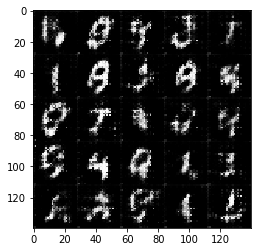

Epoch 1/2... Batch 110... Discriminator Loss: 1.6149... Generator Loss: 0.4342
Epoch 1/2... Batch 120... Discriminator Loss: 1.4693... Generator Loss: 0.5286
Epoch 1/2... Batch 130... Discriminator Loss: 1.5209... Generator Loss: 0.4825
Epoch 1/2... Batch 140... Discriminator Loss: 1.4394... Generator Loss: 0.5610
Epoch 1/2... Batch 150... Discriminator Loss: 1.4047... Generator Loss: 0.5623
Epoch 1/2... Batch 160... Discriminator Loss: 1.4850... Generator Loss: 0.5500
Epoch 1/2... Batch 170... Discriminator Loss: 1.5019... Generator Loss: 0.5268
Epoch 1/2... Batch 180... Discriminator Loss: 1.4210... Generator Loss: 0.5821
Epoch 1/2... Batch 190... Discriminator Loss: 1.3469... Generator Loss: 0.6791
Epoch 1/2... Batch 200... Discriminator Loss: 1.4403... Generator Loss: 0.5875


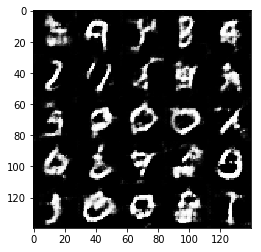

Epoch 1/2... Batch 210... Discriminator Loss: 1.4218... Generator Loss: 0.5964
Epoch 1/2... Batch 220... Discriminator Loss: 1.4427... Generator Loss: 0.5907
Epoch 1/2... Batch 230... Discriminator Loss: 1.3756... Generator Loss: 0.6570
Epoch 1/2... Batch 240... Discriminator Loss: 1.4972... Generator Loss: 0.5434
Epoch 1/2... Batch 250... Discriminator Loss: 1.4219... Generator Loss: 0.5799
Epoch 1/2... Batch 260... Discriminator Loss: 1.4315... Generator Loss: 0.6114
Epoch 1/2... Batch 270... Discriminator Loss: 1.3568... Generator Loss: 0.6863
Epoch 1/2... Batch 280... Discriminator Loss: 1.3786... Generator Loss: 0.7715
Epoch 1/2... Batch 290... Discriminator Loss: 1.4975... Generator Loss: 0.5163
Epoch 1/2... Batch 300... Discriminator Loss: 1.4426... Generator Loss: 0.5711


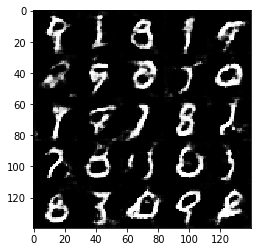

Epoch 1/2... Batch 310... Discriminator Loss: 1.3885... Generator Loss: 0.6570
Epoch 1/2... Batch 320... Discriminator Loss: 1.4222... Generator Loss: 1.2021
Epoch 1/2... Batch 330... Discriminator Loss: 1.4240... Generator Loss: 0.9798
Epoch 1/2... Batch 340... Discriminator Loss: 1.3372... Generator Loss: 0.8943
Epoch 1/2... Batch 350... Discriminator Loss: 1.3929... Generator Loss: 1.1769
Epoch 1/2... Batch 360... Discriminator Loss: 1.3583... Generator Loss: 0.8126
Epoch 1/2... Batch 370... Discriminator Loss: 1.3542... Generator Loss: 0.9756
Epoch 1/2... Batch 380... Discriminator Loss: 1.5305... Generator Loss: 1.2069
Epoch 1/2... Batch 390... Discriminator Loss: 1.3870... Generator Loss: 1.0317
Epoch 1/2... Batch 400... Discriminator Loss: 1.3383... Generator Loss: 0.8251


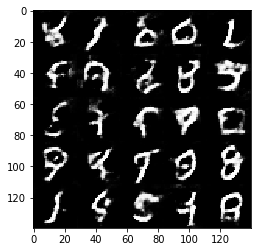

Epoch 1/2... Batch 410... Discriminator Loss: 1.3800... Generator Loss: 0.6710
Epoch 1/2... Batch 420... Discriminator Loss: 1.3979... Generator Loss: 0.5883
Epoch 1/2... Batch 430... Discriminator Loss: 1.4101... Generator Loss: 0.5885
Epoch 1/2... Batch 440... Discriminator Loss: 1.3942... Generator Loss: 0.5906
Epoch 1/2... Batch 450... Discriminator Loss: 1.3578... Generator Loss: 0.6634
Epoch 1/2... Batch 460... Discriminator Loss: 1.4079... Generator Loss: 1.1614
Epoch 2/2... Batch 470... Discriminator Loss: 1.4860... Generator Loss: 1.1439
Epoch 2/2... Batch 480... Discriminator Loss: 1.3475... Generator Loss: 1.0807
Epoch 2/2... Batch 490... Discriminator Loss: 1.3765... Generator Loss: 1.0604
Epoch 2/2... Batch 500... Discriminator Loss: 1.4249... Generator Loss: 1.0966


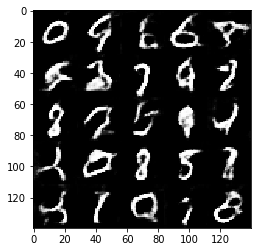

Epoch 2/2... Batch 510... Discriminator Loss: 1.3890... Generator Loss: 0.9483
Epoch 2/2... Batch 520... Discriminator Loss: 1.3243... Generator Loss: 0.9929
Epoch 2/2... Batch 530... Discriminator Loss: 1.4020... Generator Loss: 1.0545
Epoch 2/2... Batch 540... Discriminator Loss: 1.3994... Generator Loss: 1.0257
Epoch 2/2... Batch 550... Discriminator Loss: 1.3113... Generator Loss: 0.8492
Epoch 2/2... Batch 560... Discriminator Loss: 1.4850... Generator Loss: 0.5020
Epoch 2/2... Batch 570... Discriminator Loss: 1.3894... Generator Loss: 0.6042
Epoch 2/2... Batch 580... Discriminator Loss: 1.3811... Generator Loss: 0.6123
Epoch 2/2... Batch 590... Discriminator Loss: 1.3731... Generator Loss: 0.6243
Epoch 2/2... Batch 600... Discriminator Loss: 1.4191... Generator Loss: 0.5518


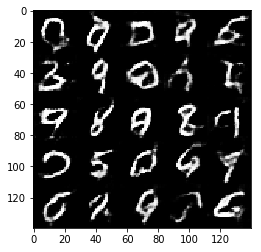

Epoch 2/2... Batch 610... Discriminator Loss: 1.3748... Generator Loss: 0.6272
Epoch 2/2... Batch 620... Discriminator Loss: 1.4108... Generator Loss: 0.5865
Epoch 2/2... Batch 630... Discriminator Loss: 1.4343... Generator Loss: 0.5555
Epoch 2/2... Batch 640... Discriminator Loss: 1.3103... Generator Loss: 0.7308
Epoch 2/2... Batch 650... Discriminator Loss: 1.4572... Generator Loss: 0.4988
Epoch 2/2... Batch 660... Discriminator Loss: 1.3311... Generator Loss: 0.6743
Epoch 2/2... Batch 670... Discriminator Loss: 1.4920... Generator Loss: 0.4739
Epoch 2/2... Batch 680... Discriminator Loss: 1.3071... Generator Loss: 0.7059
Epoch 2/2... Batch 690... Discriminator Loss: 1.4303... Generator Loss: 0.5416
Epoch 2/2... Batch 700... Discriminator Loss: 1.3791... Generator Loss: 0.6092


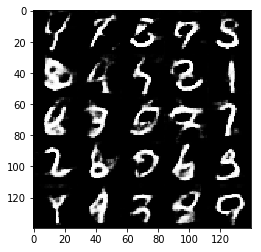

Epoch 2/2... Batch 710... Discriminator Loss: 1.3227... Generator Loss: 0.6866
Epoch 2/2... Batch 720... Discriminator Loss: 1.3698... Generator Loss: 0.6282
Epoch 2/2... Batch 730... Discriminator Loss: 1.4400... Generator Loss: 0.5477
Epoch 2/2... Batch 740... Discriminator Loss: 1.3374... Generator Loss: 0.6447
Epoch 2/2... Batch 750... Discriminator Loss: 1.3693... Generator Loss: 0.6120
Epoch 2/2... Batch 760... Discriminator Loss: 1.3208... Generator Loss: 0.6571
Epoch 2/2... Batch 770... Discriminator Loss: 1.4840... Generator Loss: 0.5006
Epoch 2/2... Batch 780... Discriminator Loss: 1.3351... Generator Loss: 0.7035
Epoch 2/2... Batch 790... Discriminator Loss: 1.2920... Generator Loss: 0.9180
Epoch 2/2... Batch 800... Discriminator Loss: 1.3835... Generator Loss: 1.2264


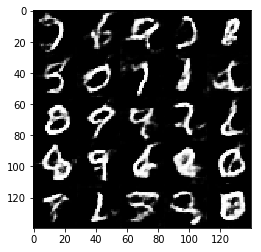

Epoch 2/2... Batch 810... Discriminator Loss: 1.3637... Generator Loss: 1.0346
Epoch 2/2... Batch 820... Discriminator Loss: 1.3142... Generator Loss: 0.9190
Epoch 2/2... Batch 830... Discriminator Loss: 1.3397... Generator Loss: 0.9831
Epoch 2/2... Batch 840... Discriminator Loss: 1.4048... Generator Loss: 1.0828
Epoch 2/2... Batch 850... Discriminator Loss: 1.3852... Generator Loss: 1.0529
Epoch 2/2... Batch 860... Discriminator Loss: 1.3163... Generator Loss: 0.9969
Epoch 2/2... Batch 870... Discriminator Loss: 1.4014... Generator Loss: 1.0500
Epoch 2/2... Batch 880... Discriminator Loss: 1.3729... Generator Loss: 1.0635
Epoch 2/2... Batch 890... Discriminator Loss: 1.3021... Generator Loss: 0.8128
Epoch 2/2... Batch 900... Discriminator Loss: 1.3940... Generator Loss: 0.5723


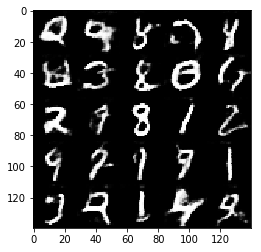

Epoch 2/2... Batch 910... Discriminator Loss: 1.4250... Generator Loss: 0.6256
Epoch 2/2... Batch 920... Discriminator Loss: 1.3945... Generator Loss: 0.5951
Epoch 2/2... Batch 930... Discriminator Loss: 1.3574... Generator Loss: 0.6463


In [87]:
batch_size = 64
z_dim = 100
learning_rate = .01
beta1 = .02


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 11.2797... Generator Loss: 14.8467
Epoch 1/1... Batch 20... Discriminator Loss: 3.6522... Generator Loss: 9.6377
Epoch 1/1... Batch 30... Discriminator Loss: 4.0887... Generator Loss: 8.1638
Epoch 1/1... Batch 40... Discriminator Loss: 1.6882... Generator Loss: 1.0167
Epoch 1/1... Batch 50... Discriminator Loss: 1.2953... Generator Loss: 1.2815
Epoch 1/1... Batch 60... Discriminator Loss: 1.6359... Generator Loss: 3.9036
Epoch 1/1... Batch 70... Discriminator Loss: 3.4150... Generator Loss: 0.1798
Epoch 1/1... Batch 80... Discriminator Loss: 1.4107... Generator Loss: 0.6402
Epoch 1/1... Batch 90... Discriminator Loss: 1.3643... Generator Loss: 0.8637
Epoch 1/1... Batch 100... Discriminator Loss: 2.3781... Generator Loss: 0.2178


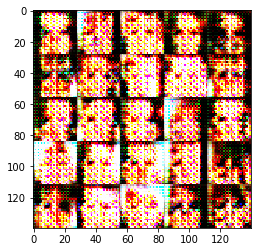

Epoch 1/1... Batch 110... Discriminator Loss: 1.8341... Generator Loss: 4.0941
Epoch 1/1... Batch 120... Discriminator Loss: 0.9322... Generator Loss: 1.6830
Epoch 1/1... Batch 130... Discriminator Loss: 2.3482... Generator Loss: 3.7272
Epoch 1/1... Batch 140... Discriminator Loss: 0.9282... Generator Loss: 1.6714
Epoch 1/1... Batch 150... Discriminator Loss: 0.7033... Generator Loss: 1.9836
Epoch 1/1... Batch 160... Discriminator Loss: 1.4981... Generator Loss: 0.4661
Epoch 1/1... Batch 170... Discriminator Loss: 0.5505... Generator Loss: 2.1689
Epoch 1/1... Batch 180... Discriminator Loss: 0.9591... Generator Loss: 1.0400
Epoch 1/1... Batch 190... Discriminator Loss: 1.8807... Generator Loss: 0.5587
Epoch 1/1... Batch 200... Discriminator Loss: 0.5362... Generator Loss: 1.9073


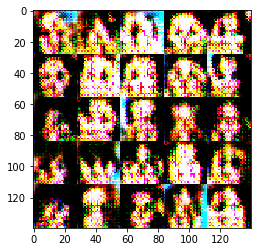

Epoch 1/1... Batch 210... Discriminator Loss: 0.4659... Generator Loss: 2.5229
Epoch 1/1... Batch 220... Discriminator Loss: 0.4265... Generator Loss: 2.8472
Epoch 1/1... Batch 230... Discriminator Loss: 3.0515... Generator Loss: 7.9001
Epoch 1/1... Batch 240... Discriminator Loss: 1.1444... Generator Loss: 2.1456
Epoch 1/1... Batch 250... Discriminator Loss: 0.9811... Generator Loss: 2.1319
Epoch 1/1... Batch 260... Discriminator Loss: 0.5697... Generator Loss: 2.9430
Epoch 1/1... Batch 270... Discriminator Loss: 0.9865... Generator Loss: 1.1086
Epoch 1/1... Batch 280... Discriminator Loss: 0.4357... Generator Loss: 2.6786
Epoch 1/1... Batch 290... Discriminator Loss: 0.9897... Generator Loss: 0.8788
Epoch 1/1... Batch 300... Discriminator Loss: 1.6088... Generator Loss: 0.9670


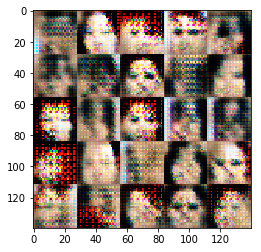

Epoch 1/1... Batch 310... Discriminator Loss: 0.5646... Generator Loss: 2.3871
Epoch 1/1... Batch 320... Discriminator Loss: 0.4974... Generator Loss: 2.0270
Epoch 1/1... Batch 330... Discriminator Loss: 0.3701... Generator Loss: 3.9517
Epoch 1/1... Batch 340... Discriminator Loss: 1.7805... Generator Loss: 1.5071
Epoch 1/1... Batch 350... Discriminator Loss: 1.3497... Generator Loss: 1.3630
Epoch 1/1... Batch 360... Discriminator Loss: 1.4223... Generator Loss: 1.8057
Epoch 1/1... Batch 370... Discriminator Loss: 1.3930... Generator Loss: 1.6045
Epoch 1/1... Batch 380... Discriminator Loss: 1.4079... Generator Loss: 1.5318
Epoch 1/1... Batch 390... Discriminator Loss: 1.5998... Generator Loss: 1.9141
Epoch 1/1... Batch 400... Discriminator Loss: 1.3319... Generator Loss: 1.2583


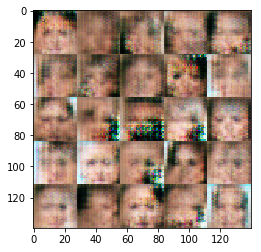

Epoch 1/1... Batch 410... Discriminator Loss: 1.8763... Generator Loss: 1.7540
Epoch 1/1... Batch 420... Discriminator Loss: 1.3771... Generator Loss: 0.5124
Epoch 1/1... Batch 430... Discriminator Loss: 1.3173... Generator Loss: 0.6058
Epoch 1/1... Batch 440... Discriminator Loss: 0.4854... Generator Loss: 2.2618
Epoch 1/1... Batch 450... Discriminator Loss: 2.1617... Generator Loss: 1.6877
Epoch 1/1... Batch 460... Discriminator Loss: 1.4348... Generator Loss: 1.0760
Epoch 1/1... Batch 470... Discriminator Loss: 1.5560... Generator Loss: 1.1406
Epoch 1/1... Batch 480... Discriminator Loss: 1.4043... Generator Loss: 1.0943
Epoch 1/1... Batch 490... Discriminator Loss: 1.2638... Generator Loss: 1.1363
Epoch 1/1... Batch 500... Discriminator Loss: 1.3445... Generator Loss: 1.0961


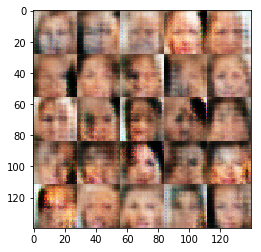

Epoch 1/1... Batch 510... Discriminator Loss: 1.4728... Generator Loss: 1.2216
Epoch 1/1... Batch 520... Discriminator Loss: 1.4344... Generator Loss: 1.0300
Epoch 1/1... Batch 530... Discriminator Loss: 1.5123... Generator Loss: 1.4630
Epoch 1/1... Batch 540... Discriminator Loss: 1.3144... Generator Loss: 1.0187
Epoch 1/1... Batch 550... Discriminator Loss: 1.3497... Generator Loss: 1.1130
Epoch 1/1... Batch 560... Discriminator Loss: 1.3738... Generator Loss: 1.2380
Epoch 1/1... Batch 570... Discriminator Loss: 1.4823... Generator Loss: 1.3014
Epoch 1/1... Batch 580... Discriminator Loss: 1.4032... Generator Loss: 1.0107
Epoch 1/1... Batch 590... Discriminator Loss: 1.3862... Generator Loss: 1.0594
Epoch 1/1... Batch 600... Discriminator Loss: 1.3621... Generator Loss: 1.1815


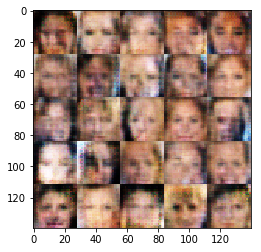

Epoch 1/1... Batch 610... Discriminator Loss: 1.3923... Generator Loss: 1.0019
Epoch 1/1... Batch 620... Discriminator Loss: 1.4960... Generator Loss: 0.4916
Epoch 1/1... Batch 630... Discriminator Loss: 1.3819... Generator Loss: 0.6666
Epoch 1/1... Batch 640... Discriminator Loss: 1.4233... Generator Loss: 0.6070
Epoch 1/1... Batch 650... Discriminator Loss: 1.3074... Generator Loss: 0.8062
Epoch 1/1... Batch 660... Discriminator Loss: 1.3691... Generator Loss: 0.6321
Epoch 1/1... Batch 670... Discriminator Loss: 1.4208... Generator Loss: 0.5565
Epoch 1/1... Batch 680... Discriminator Loss: 1.4011... Generator Loss: 0.6030
Epoch 1/1... Batch 690... Discriminator Loss: 1.3914... Generator Loss: 0.6887
Epoch 1/1... Batch 700... Discriminator Loss: 1.3888... Generator Loss: 0.6337


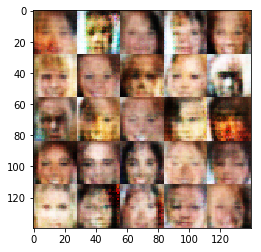

Epoch 1/1... Batch 710... Discriminator Loss: 1.3089... Generator Loss: 0.7481
Epoch 1/1... Batch 720... Discriminator Loss: 1.4841... Generator Loss: 0.5187
Epoch 1/1... Batch 730... Discriminator Loss: 1.3551... Generator Loss: 0.7626
Epoch 1/1... Batch 740... Discriminator Loss: 1.3963... Generator Loss: 0.6316
Epoch 1/1... Batch 750... Discriminator Loss: 1.3710... Generator Loss: 0.6925
Epoch 1/1... Batch 760... Discriminator Loss: 1.3981... Generator Loss: 0.6696
Epoch 1/1... Batch 770... Discriminator Loss: 1.3961... Generator Loss: 0.6116
Epoch 1/1... Batch 780... Discriminator Loss: 1.4245... Generator Loss: 0.6176
Epoch 1/1... Batch 790... Discriminator Loss: 1.4086... Generator Loss: 0.5928
Epoch 1/1... Batch 800... Discriminator Loss: 1.3599... Generator Loss: 0.7482


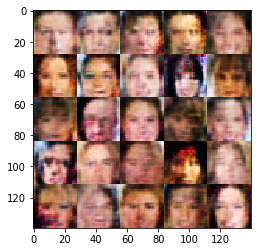

Epoch 1/1... Batch 810... Discriminator Loss: 1.4262... Generator Loss: 0.6149
Epoch 1/1... Batch 820... Discriminator Loss: 1.3591... Generator Loss: 0.8223
Epoch 1/1... Batch 830... Discriminator Loss: 1.3007... Generator Loss: 0.8930
Epoch 1/1... Batch 840... Discriminator Loss: 1.4573... Generator Loss: 0.5386


KeyboardInterrupt: 

In [89]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = .05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.